In [1]:
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
print("Working directory:", os.getcwd())

Working directory: c:\Users\benjo\OneDrive\Data Science Masters\DSMP\dsmp-2024-group-19


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import *

In [3]:
tapes = get_Tapes(125)

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

In [4]:
# use combined_time to find month of each tape
months = [tape[:1].index.date[0].month for tape in tapes]

In [5]:
def resample_tape(tape, freq="1s"):
    resampled_df = tape
    resampled_df["Price*Volume"] = resampled_df["Price"] * resampled_df["Volume"]
    resampled_df = resampled_df.resample(freq).sum()
    resampled_df["Price"] = resampled_df["Price*Volume"] / resampled_df["Volume"]
    resampled_df["Price"] = resampled_df["Price"].fillna(method='ffill')
    return resampled_df

def resamples_tapes(tapes, freq="1s"):
    resampled_tapes = {}
    for i,tape in enumerate(tapes):
        resampled_tapes[i] = resample_tape(tape, freq)
    return resampled_tapes

In [6]:
resampled_tapes = resamples_tapes(tapes, freq="1s")

In [7]:
# group tapes by month
tapes_by_month = {}
for i, month in enumerate(months):
    if month not in tapes_by_month:
        tapes_by_month[month] = []
    tapes_by_month[month].append(resampled_tapes[i])

In [8]:
tapes_summ = pd.DataFrame()

for i in resampled_tapes:
    avg_price = resampled_tapes[i]["Price"].mean()
    vol = resampled_tapes[i]["Volume"].sum()
    trend = resampled_tapes[i]["Price"].diff().mean()
    std = resampled_tapes[i]["Price"].std()
    min = resampled_tapes[i]["Price"].min()
    q25 = resampled_tapes[i]["Price"].quantile(0.25)
    q50 = resampled_tapes[i]["Price"].quantile(0.50)
    q75 = resampled_tapes[i]["Price"].quantile(0.75)
    max = resampled_tapes[i]["Price"].max()
    tapes_summ = tapes_summ.append({"Avg_Price": avg_price, "Volume": vol, "Trend": trend, "Std": std, "Min": min, "Q25": q25, "Q50": q50, "Q75": q75, "Max": max}, ignore_index=True)

C:\Users\benjo\AppData\Local\Temp\ipykernel_3340\3016133249.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tapes_summ = tapes_summ.append({"Avg_Price": avg_price, "Volume": vol, "Trend": trend, "Std": std, "Min": min, "Q25": q25, "Q50": q50, "Q75": q75, "Max": max}, ignore_index=True)
C:\Users\benjo\AppData\Local\Temp\ipykernel_3340\3016133249.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tapes_summ = tapes_summ.append({"Avg_Price": avg_price, "Volume": vol, "Trend": trend, "Std": std, "Min": min, "Q25": q25, "Q50": q50, "Q75": q75, "Max": max}, ignore_index=True)
C:\Users\benjo\AppData\Local\Temp\ipykernel_3340\3016133249.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tapes_summ = tapes_summ.append({"Avg

In [9]:
tapes_summ.head()

,Avg_Price,Volume,Trend,Std,Min,Q25,Q50,Q75,Max
0,281.665176,47973.0,0.000752,12.500882,243.0,274.000000,286.000000,291.000000,303.0
1,296.287712,51992.0,0.000340,7.544433,270.0,291.000000,296.000000,301.191667,317.0
2,311.951727,48047.0,0.001602,13.995817,276.0,300.000000,313.291667,323.000000,346.0
3,356.419124,44335.0,0.001152,16.690889,317.0,339.309524,359.400000,371.000000,387.0
4,336.118059,44859.0,-0.001765,13.315800,303.0,326.000000,334.000000,346.333333,374.0


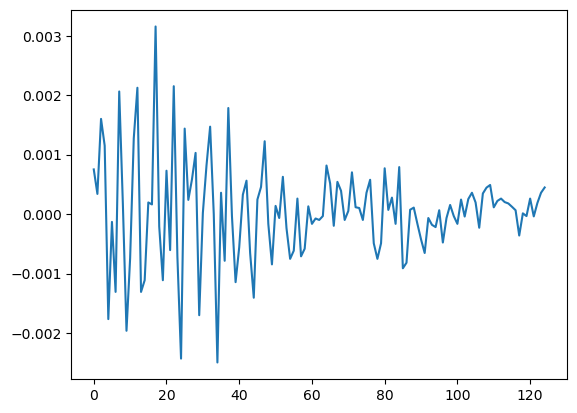

In [18]:
# tapes_summ trend
plt.plot(tapes_summ["Trend"])


In [14]:
# calculate monthly average of statistics 
monthly_avg = pd.DataFrame()
from hurst import compute_Hc

for month in tapes_by_month:
    month_df = pd.DataFrame()
    for tape in tapes_by_month[month]:
        avg_price = tape["Price"].mean()
        vol = tape["Volume"].sum()
        trend = tape["Price"].diff().mean()
        std = tape["Price"].std()
        min = tape["Price"].min()
        q25 = tape["Price"].quantile(0.25)
        q50 = tape["Price"].quantile(0.50)
        q75 = tape["Price"].quantile(0.75)
        max = tape["Price"].max()
        Hc, c, data = compute_Hc(tape["Price"], kind='price', simplified=True)
        month_df = month_df.append({"Avg_Price": avg_price, "Volume": vol, "Trend": trend, "Std": std, "Min": min, "Q25": q25, "Q50": q50, "Q75": q75, "Max": max, "Hc": Hc}, ignore_index=True)
    monthly_avg = monthly_avg.append(month_df.mean(), ignore_index=True)

C:\Users\benjo\AppData\Local\Temp\ipykernel_3340\2998186501.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_df = month_df.append({"Avg_Price": avg_price, "Volume": vol, "Trend": trend, "Std": std, "Min": min, "Q25": q25, "Q50": q50, "Q75": q75, "Max": max, "Hc": Hc}, ignore_index=True)
C:\Users\benjo\AppData\Local\Temp\ipykernel_3340\2998186501.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_df = month_df.append({"Avg_Price": avg_price, "Volume": vol, "Trend": trend, "Std": std, "Min": min, "Q25": q25, "Q50": q50, "Q75": q75, "Max": max, "Hc": Hc}, ignore_index=True)
C:\Users\benjo\AppData\Local\Temp\ipykernel_3340\2998186501.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_df = month_df.appe

In [15]:
monthly_avg

,Avg_Price,Volume,Trend,Std,Min,Q25,Q50,Q75,Max,Hc
0,318.734202,48167.909091,0.000158,12.642633,284.800000,309.065963,318.977652,328.735985,347.737229,0.234383
1,298.727669,51240.350000,0.000018,11.561566,267.377381,290.146512,298.325000,307.889167,325.800000,0.224838
2,192.531624,55583.238095,-0.000129,6.307437,170.557143,188.399471,192.889569,197.220635,207.285714,0.180439
3,158.294586,55955.300000,0.000157,4.998045,139.450000,155.215833,158.569583,161.852381,170.000000,0.165897
4,152.565248,55830.750000,-0.000147,4.897329,134.325000,149.473483,152.853929,155.977992,164.350000,0.164369
5,110.676660,55634.476190,0.000163,3.633834,95.619048,108.821429,111.193122,113.192063,116.476190,0.138481
6,107.903178,55439.000000,0.000448,3.306993,93.000000,106.600000,108.200000,110.000000,114.000000,0.160163
